In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
import datetime

warnings.filterwarnings("ignore")
%matplotlib inline
torch.__version__

'2.4.1+cu118'

### 加载数据

In [64]:
features = pd.read_csv('../data/temps.csv')
print(f"数据维度: {features.shape}")
features.head()

数据维度: (348, 9)


,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [65]:
# 年,月,日
years = features["year"]
months = features["month"]
days = features["day"]

# datetime
dates = [f"{year}-{month}-{day}" for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in dates]
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

### 画张图试试

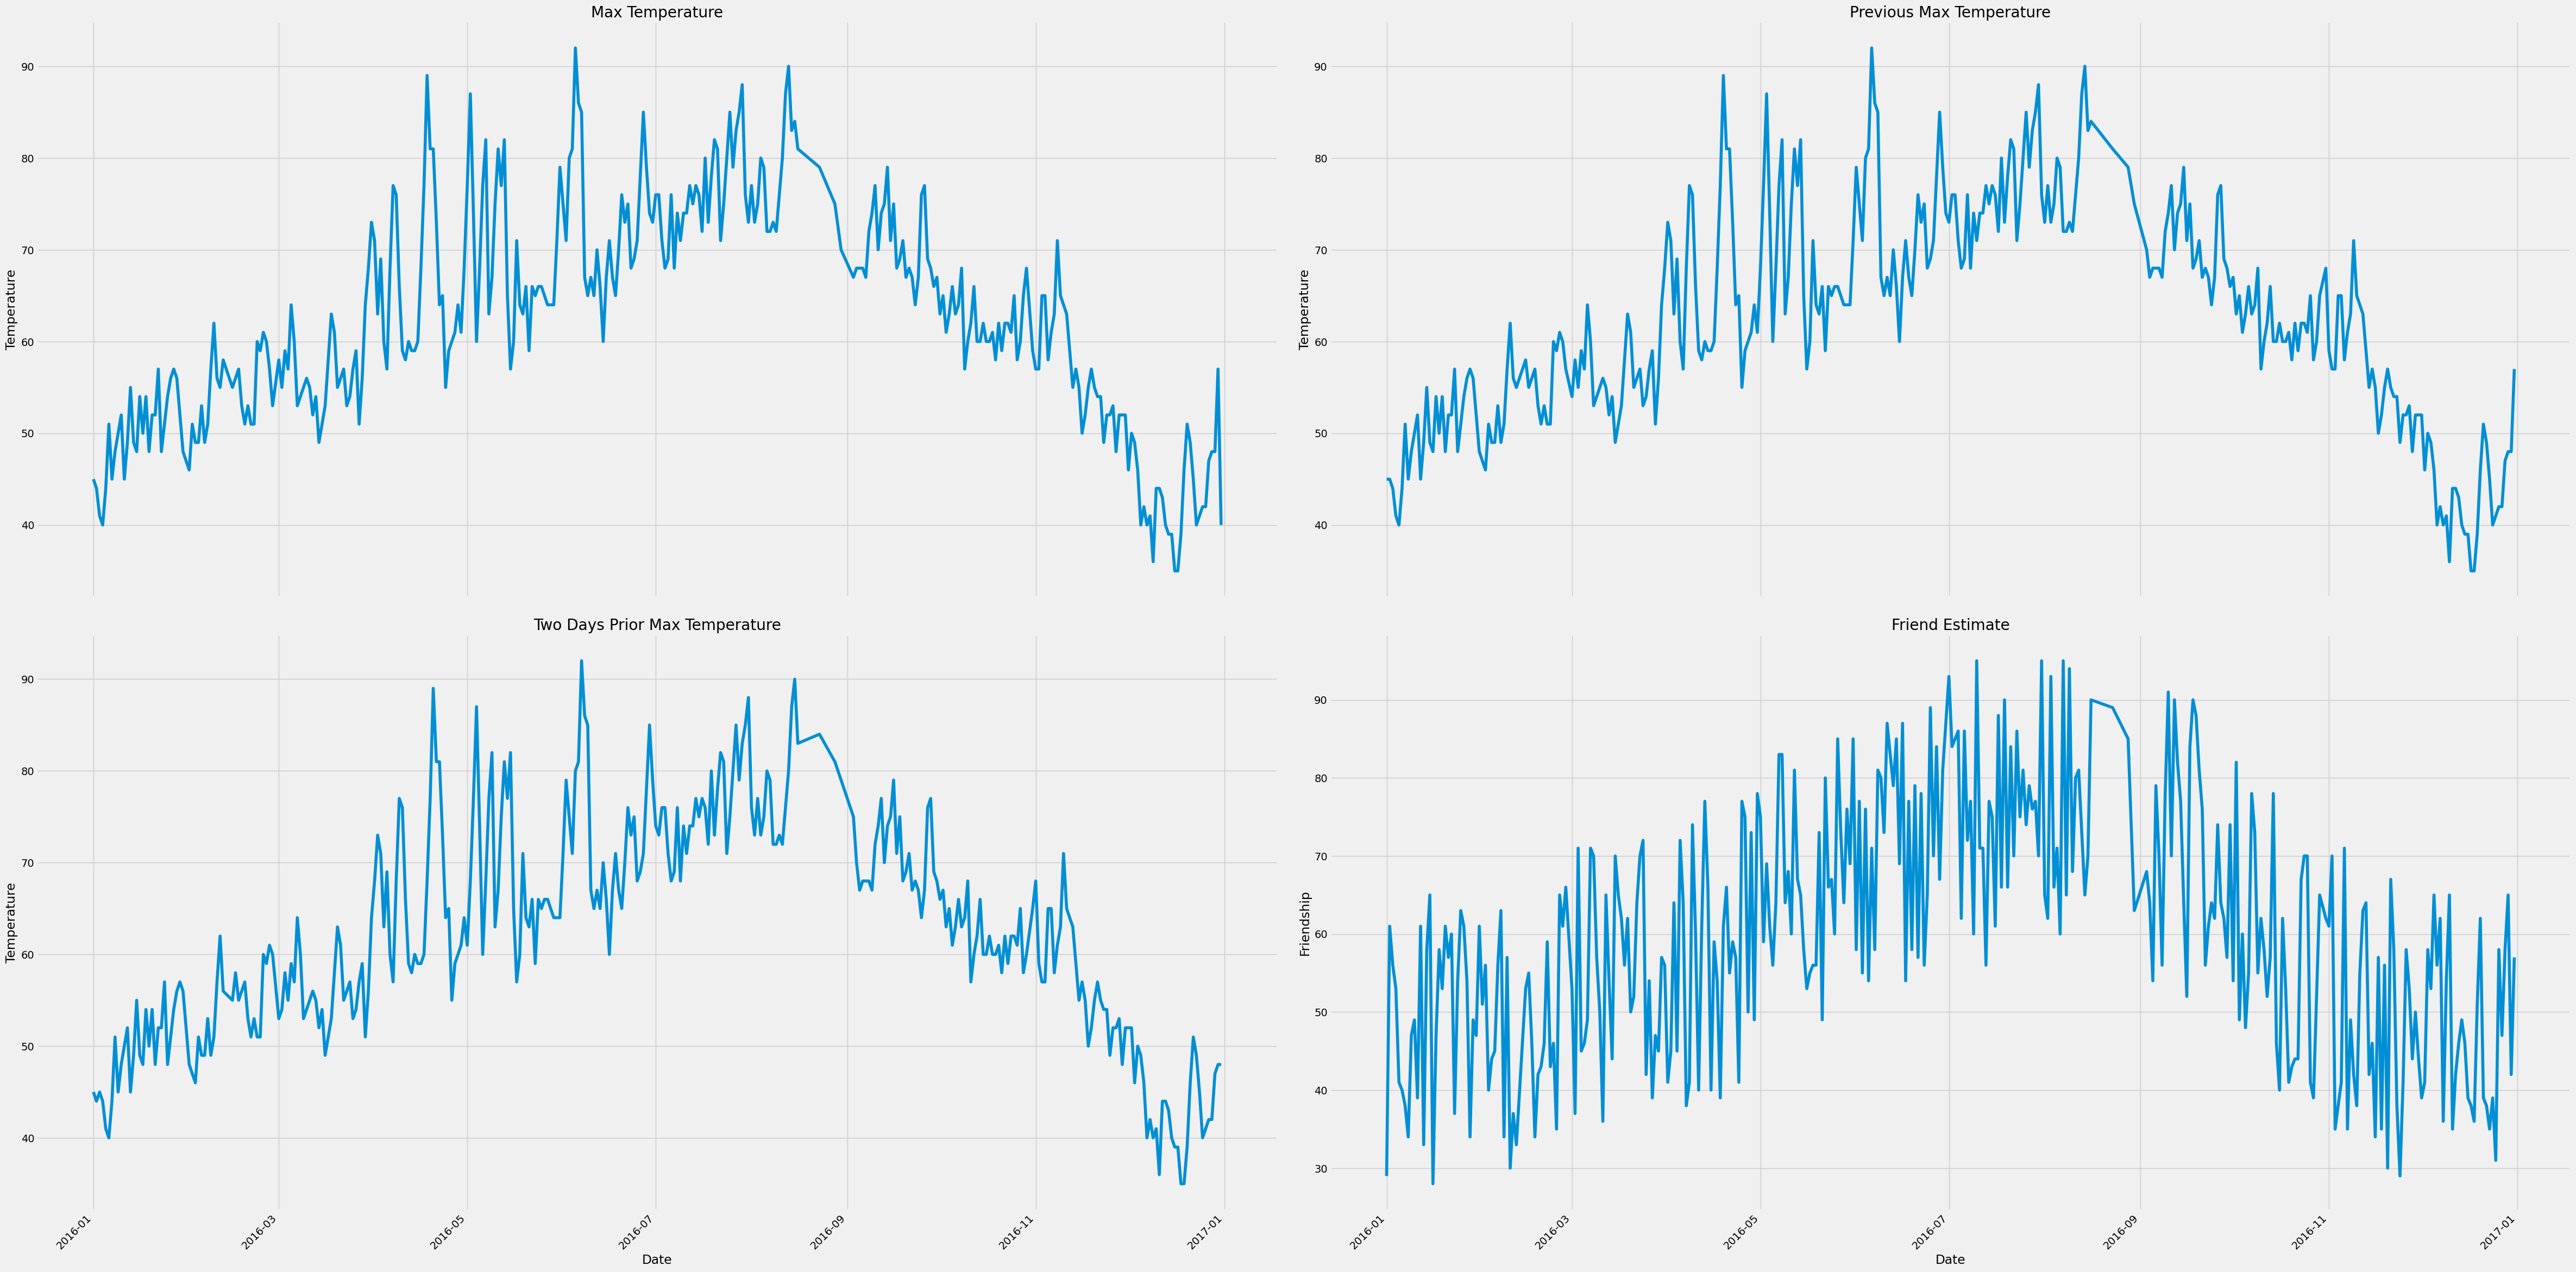

In [66]:
# 指定默认风格
plt.style.use("fivethirtyeight")
# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(48, 24))
fig.autofmt_xdate(rotation=45)
# 标签值
ax1.plot(dates, features["actual"])
ax1.set_xlabel("")
ax1.set_ylabel("Temperature")
ax1.set_title("Max Temperature")
# 昨天
ax2.plot(dates, features["temp_1"])
ax2.set_xlabel("")
ax2.set_ylabel("Temperature")
ax2.set_title("Previous Max Temperature")
# 前天
ax3.plot(dates, features["temp_2"])
ax3.set_xlabel("Date")
ax3.set_ylabel("Temperature")
ax3.set_title("Two Days Prior Max Temperature")
# 我的逗逼朋友
ax4.plot(dates, features["friend"])
ax4.set_xlabel("Date")
ax4.set_ylabel("Friendship")
ax4.set_title("Friend Estimate")

plt.tight_layout(pad=2)
plt.show()


### 独热编码（One-Hot Encoding）
pandas.get_dummies 是 Pandas 库中的一个函数，用于进行独热编码（One-Hot Encoding）。这个函数的主要作用是将分类变量转换为二进制（0和1）的矩阵表示。

In [67]:
features = pd.get_dummies(features)
print(features.shape)
features.head(5)

(348, 15)


,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False


In [68]:
# 标签
labels = np.array(features["actual"])
# 在特征中去掉标签
features = features.drop(["actual"], axis="columns")
features

,year,month,day,temp_2,temp_1,average,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,41,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,42,42,45.2,47,False,False,False,False,False,True,False
344,2016,12,28,42,47,45.3,58,False,False,False,False,False,False,True
345,2016,12,29,47,48,45.3,65,False,False,False,False,True,False,False
346,2016,12,30,48,48,45.4,42,True,False,False,False,False,False,False


In [69]:
# 名字单独保存
features_list = list(features.columns)
print(features_list)
# 转换成合适的格式
features = np.array(features)
print(features.shape)

['year', 'month', 'day', 'temp_2', 'temp_1', 'average', 'friend', 'week_Fri', 'week_Mon', 'week_Sat', 'week_Sun', 'week_Thurs', 'week_Tues', 'week_Wed']
(348, 14)


### 构建网络模型

In [70]:
from sklearn import preprocessing

# StandardScaler() 创建了一个标准化缩放器对象
# fit_transform() 方法执行两个步骤 1. fit: 计算每个特征的平均值和标准差 2. transform: 使用计算出的平均值和标准差对特征进行标准化
# 这种处理 1. 使不同尺度的特征具有可比性 2. 消除量纲影响 3. 有助于某些机器学习算法的收敛和性能
input_features = preprocessing.StandardScaler().fit_transform(features)
input_features

array([[ 0.        , -1.5678393 , -1.65682171, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.54267126, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.4285208 , ..., -0.40482045,
        -0.41913682, -0.40482045],
       ...,
       [ 0.        ,  1.5810006 ,  1.53939107, ...,  2.47023092,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.65354153, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.76769198, ..., -0.40482045,
        -0.41913682, -0.40482045]])

In [72]:
x = torch.tensor(input_features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.float)
# 权重参数初始化
weights = torch.randn((14, 128), dtype=torch.float, requires_grad=True)
biases = torch.randn(128, dtype=torch.float, requires_grad=True)
weights2 = torch.randn((128, 1), dtype=torch.float, requires_grad=True)
biases2 = torch.randn(1, dtype=torch.float, requires_grad=True)

learning_rate = 0.001
losses = []

for epoch in range(1000):
    # 计算隐层 mm:矩阵乘法
    hidden = x.mm(weights) + biases
    # 加入激活函数
    hidden = torch.relu(hidden)
    # 预测结果
    predictions = hidden.mm(weights2) + biases2
    # 计算损失
    loss = torch.mean((predictions - y) ** 2)
    losses.append(loss.data.numpy())

    # 打印损失值
    if epoch % 100 == 0:
        print(f"loss:{loss}")
    # 返向传播计算
    loss.backward()

    # 更新参数
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases2.data.add_(- learning_rate * biases2.grad.data)

    # 每次迭代都得记得清空
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()


loss:3668.510498046875
loss:156.6771697998047
loss:147.14666748046875
loss:144.18978881835938
loss:142.78396606445312
loss:141.94277954101562
loss:141.37838745117188
loss:140.9617462158203
loss:140.6588592529297
loss:140.427001953125
loss:140.2431182861328
loss:140.09103393554688
loss:139.9652557373047
loss:139.85971069335938
loss:139.76983642578125
loss:139.6924285888672
loss:139.6259765625
loss:139.56797790527344
loss:139.51536560058594
loss:139.4676971435547
loss:139.4247589111328
loss:139.38409423828125
loss:139.34693908691406
loss:139.31362915039062
loss:139.28335571289062
loss:139.25538635253906
loss:139.23007202148438
loss:139.20657348632812
loss:139.18490600585938
loss:139.16494750976562
loss:139.1462860107422
loss:139.12892150878906
loss:139.112548828125
loss:139.09710693359375
loss:139.08255004882812
loss:139.06883239746094
loss:139.05575561523438
loss:139.0434112548828
loss:139.03164672851562
loss:139.0205535888672
loss:139.010009765625
loss:138.99998474121094
loss:138.99049

### 更简单的构建网络模型

In [75]:
input_size = input_features.shape[1]
print(input_size)
hidden_size = 128
output_size = 1
batch_size = 16
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)
cost = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(my_nn.parameters(), lr=learning_rate)

14


In [76]:
losses = []
for epoch in range(1000):
    batch_loss = []
    # MLNI-Batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(labels[start:end], dtype=torch.float, requires_grad=True)
        prediction = my_nn(xx)
        loss = cost(prediction, yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        # 打印损失
        if epoch % 100 == 0:
            losses.append(np.mean(batch_loss))
            print(f"epoch: {epoch},loss: {np.mean(batch_loss)}")

epoch: 0,loss: 2261.90380859375
epoch: 0,loss: 2467.82763671875
epoch: 0,loss: 2608.356201171875
epoch: 0,loss: 2761.144287109375
epoch: 0,loss: 2810.80224609375
epoch: 0,loss: 3024.9365234375
epoch: 0,loss: 3241.263916015625
epoch: 0,loss: 3429.97998046875
epoch: 0,loss: 3545.8193359375
epoch: 0,loss: 3730.407470703125
epoch: 0,loss: 3839.998291015625
epoch: 0,loss: 3961.499755859375
epoch: 0,loss: 4130.43603515625
epoch: 0,loss: 4255.75439453125
epoch: 0,loss: 4320.52197265625
epoch: 0,loss: 4350.3193359375
epoch: 0,loss: 4319.626953125
epoch: 0,loss: 4279.2109375
epoch: 0,loss: 4236.873046875
epoch: 0,loss: 4152.97705078125
epoch: 0,loss: 4028.51220703125
epoch: 0,loss: 3935.856201171875
epoch: 100,loss: 25.14422607421875
epoch: 100,loss: 21.448516845703125
epoch: 100,loss: 20.67765235900879
epoch: 100,loss: 20.409748077392578
epoch: 100,loss: 20.61583709716797
epoch: 100,loss: 29.794631958007812
epoch: 100,loss: 41.89142608642578
epoch: 100,loss: 47.227516174316406
epoch: 100,loss:

### 预训练结果

In [78]:
x = torch.tensor(input_features, dtype=torch.float)
predict = my_nn(x).data.numpy()
print(predict)

[[47.401302]
 [47.654793]
 [47.14987 ]
 [46.95647 ]
 [47.558125]
 [47.041275]
 [47.539852]
 [48.7497  ]
 [48.71213 ]
 [49.545895]
 [50.868824]
 [49.806225]
 [49.401897]
 [50.420727]
 [49.435062]
 [49.670265]
 [51.39524 ]
 [51.808346]
 [52.345848]
 [51.31494 ]
 [50.845352]
 [50.614506]
 [52.387177]
 [52.635468]
 [51.76572 ]
 [53.011166]
 [53.540474]
 [53.67374 ]
 [53.54574 ]
 [53.378796]
 [52.499043]
 [49.99528 ]
 [50.78358 ]
 [51.34397 ]
 [51.19756 ]
 [51.24822 ]
 [52.28576 ]
 [51.813087]
 [52.644573]
 [54.214615]
 [55.499233]
 [55.13481 ]
 [54.580906]
 [54.933327]
 [55.70655 ]
 [55.026897]
 [54.778103]
 [54.732292]
 [53.945766]
 [54.478573]
 [54.597225]
 [55.337067]
 [55.711727]
 [56.698723]
 [56.413074]
 [57.968067]
 [57.491722]
 [55.55411 ]
 [56.18445 ]
 [56.336445]
 [56.85527 ]
 [57.009155]
 [57.8308  ]
 [57.407585]
 [57.066128]
 [56.4676  ]
 [56.6605  ]
 [57.824444]
 [57.438503]
 [56.45436 ]
 [57.01809 ]
 [56.534412]
 [55.973377]
 [57.27874 ]
 [58.085243]
 [60.141853]
 [60.86362 ]

### 画图-实际值-预测值

In [80]:
# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data={"data": dates, "actual": labels})

# 同理,再创建一个来存日期和其对应的模型预测值
months = features[:, features_list.index("month")]
days = features[:, features_list.index("day")]
years = features[:, features_list.index("year")]

test_dates = [f"{year}-{month}-{day}" for year, month, day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in test_dates]
predictions_data = pd.DataFrame(data={"data": test_dates, "prediction": predict.reshape(-1)})

Text(0.5, 1.0, 'Actual and Predicted Values')

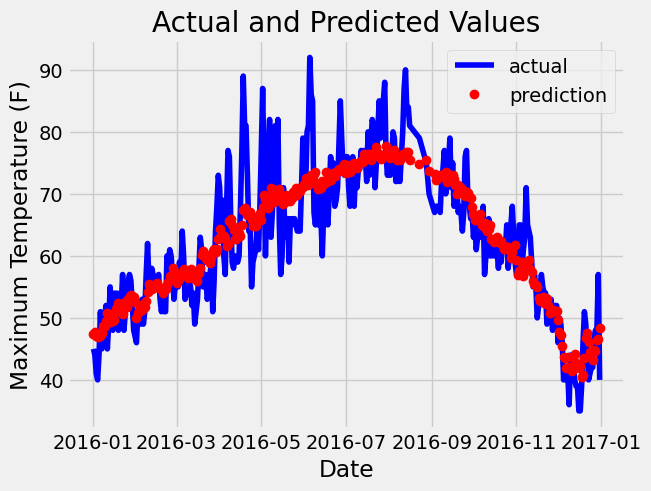

In [84]:
# 真实值
plt.plot(true_data["data"], true_data["actual"], "b-", label="actual")
# 预测值
plt.plot(predictions_data["data"], predictions_data["prediction"], "ro", label="prediction")
# plt.xticks(retation="60")
plt.legend()

# 图名
plt.xlabel("Date")
plt.ylabel("Maximum Temperature (F)")
plt.title("Actual and Predicted Values")
